To use this notebook, go to Runtime > Change Runtime Type and select GPU as the hardware accelerator.

Tips for reading this Colab:

* You can run all this code for yourself!
* The graphs are interactive!
* Use the table of contents pane in the sidebar to navigate
* Collapse irrelevant sections with the dropdown arrows
* Search the page using the search in the sidebar, not CTRL+F

## Setup (Ignore)

In [ ]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEBUG_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    # Install Neel's personal plotting utils
    %pip install git+https://github.com/neelnanda-io/neel-plotly.git
    # Install another version of node that makes PySvelte work way faster
    !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    %pip install git+https://github.com/neelnanda-io/PySvelte.git
    # Needed for PySvelte to work, v3 came out and broke things...
    %pip install typeguard==2.13.3
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/JayBaileyCS/TransformerLens.git to /tmp/pip-req-build-uzi_xpgm
  Running command git clone --filter=blob:none --quiet https://github.com/JayBaileyCS/TransformerLens.git /tmp/pip-req-build-uzi_xpgm
  Resolved https://github.com/JayBaileyCS/TransformerLens.git to commit 25da99dec1fcbf930aa453e49de4f0eafae3ef53
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 15.1 MB/s eta 0:00:00

In [ ]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio

if IN_COLAB or not DEBUG_MODE:
    # Thanks to annoying rendering issues, Plotly graphics will either show up in colab OR Vscode depending on the renderer - this is bad for developing demos! Thus creating a debug mode.
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "png"

In [ ]:
import torch
import einops
import pysvelte
from tqdm import tqdm

import transformer_lens
from transformer_lens import head_detector, HookedTransformer
from neel_plotly import line, imshow, scatter

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Using Head Detector For Premade Heads



In [ ]:
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


In [ ]:
from transformer_lens import head_detector

# See what heads are supported out of the box
head_detector.get_supported_heads()

prompt = "The head detector feature for TransformerLens allows users to check for various common heads automatically, reducing the cost of discovery."
head_scores = head_detector.detect_head(model, prompt, head_name='previous_token_head')
imshow(head_scores, zmin=-1, zmax=1, xaxis="Head", yaxis="Layer", title="Previous Head Matches")

Supported heads: ['previous_token_head', 'duplicate_token_head', 'induction_head']


We can see both L2H2 and L4H11 are doing a fair bit of previous token detection. Let's take a look and see if that pans out.

In [ ]:
_, cache = model.run_with_cache(prompt)
attention_pattern = cache["pattern", 2, "attn"].squeeze(0)
attention_pattern = einops.rearrange(attention_pattern, "heads seq1 seq2 -> seq1 seq2 heads")
print("Layer 2 Attention Heads:")
pysvelte.AttentionMulti(tokens=model.to_str_tokens(prompt), attention=attention_pattern)

Layer 2 Attention Heads:
pysvelte components appear to be unbuilt or stale
Running npm install...
Building pysvelte components with webpack...


In [ ]:
attention_pattern = cache["pattern", 4, "attn"].squeeze(0)
attention_pattern = einops.rearrange(attention_pattern, "heads seq1 seq2 -> seq1 seq2 heads")
print("Layer 4 Attention Heads:")
pysvelte.AttentionMulti(tokens=model.to_str_tokens(prompt), attention=attention_pattern)

Layer 4 Attention Heads:


As we expected, L2H2 is doing a lot of previous token detection, but doesn't appear to be a sharp previous token detection head. L4H11, on the other hand, is pretty much perfect. In fact, the only place it seems to be putting any other attention is the very first token, where it pays attention to the bos token.

Mechanistic interpretability is still a very new field, and we don't know the best ways to measure things yet. Ignoring attention paid to bos allows us to solve problems like the above, but may also give us artifically high results for a head like L4H10, which doesn't appear to be doing much of anything, but does have a bit of previous token attention going on if you squint carefully.

As such, the head detector supports both an `exclude_bos` and `exclude_current_token` argument, which ignores all bos attention and all current token attention respectively. By default these are False, but this is a pretty arbitrary decision, so feel free to try things out! You don't need a good reason to change these arguments - pick whatever best helps you find out useful things!

In [ ]:
head_scores = head_detector.detect_head(model, prompt, head_name='previous_token_head', exclude_bos=True, exclude_current_token=True)
imshow(head_scores, zmin=-1, zmax=1, xaxis="Head", yaxis="Layer", title="Previous Head Matches")

Now we have a lot more detection, including L0H3 and L5H6 which were unremarkable before. Let's check them out!

In [ ]:
attention_pattern = cache["pattern", 5, "attn"].squeeze(0)
attention_pattern = einops.rearrange(attention_pattern, "heads seq1 seq2 -> seq1 seq2 heads")
print("Layer 5 Attention Heads:")
pysvelte.AttentionMulti(tokens=model.to_str_tokens(prompt), attention=attention_pattern)

Layer 5 Attention Heads:


In [ ]:
attention_pattern = cache["pattern", 0, "attn"].squeeze(0)
attention_pattern = einops.rearrange(attention_pattern, "heads seq1 seq2 -> seq1 seq2 heads")
print("Layer 0 Attention Heads:")
pysvelte.AttentionMulti(tokens=model.to_str_tokens(prompt), attention=attention_pattern)

Layer 0 Attention Heads:


Here, we see some interesting results. L5H6 does very little, but happens to react quite strongly to the first token of "Trans|former". (Capital letters? Current word detection? We don't know)

L0H3 reacts almost entirely to the current token, but what little it does outside of this pays attention to the previous token. Again, it seems to be careing about the first token of "Trans|former".

In order to more fully automate these heads, we'll need to discover more principled ways of expressing these scores. For now, you can see how while scores may be misleading, different scores lead us to interesting results.

## Using Head Detector for Custom Heads

These heads are great, but sometimes there are more than three things going on in Transformers. [citation needed] As a result, we may want to use our head detector for things that aren't pre-included in TransformerLens. Fortunately, the head detector provides support for this, via **detection patterns.**

A detection pattern is simply a matrix of the same size as our attention pattern. We take the attention pattern, element-wise multiply it across our detection pattern, and then return what's left. Here's an example using our previous token head from earlier.

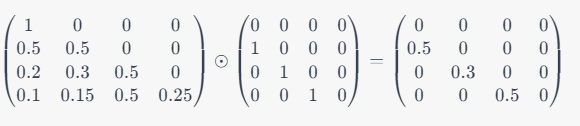

0.5, 0.3, and 0.5 all get multiplied by 1, so they get kept. All the others go to 0 and are removed. (Note: You can use values other than 0 or 1 when creating your own heads)

Our total score would then be 1.3 / 4, or 0.325. If we ignore bos and current token, it would be 0.8 / 0.95 instead, or ~0.842. (This is a large difference, but the difference generally gets smaller as the matrices get bigger)

This is how the head detector works under the hood - each existing head just has its own detection pattern. Thus, we can pass in our own detection pattern using the `detection_pattern` argument. (Note: The head detector will throw an error if you give it both a `head_name` and a `detection_pattern` argument - you need to give it exactly one!)

I'm curious what's going on with this L0H3 result, where we mostly focus on the current token but occasionally focus on the "Trans" token in "Trans|former". Let's make a **current word head** detection pattern, which returns 1 for previous tokens that are part of the current word being looked at, and 0 for everything else.

In [ ]:
prompt = "The following lexical sequence has been optimised for the maximisation of loquaciously multitoken letter combinations."
tokens = model.to_str_tokens(prompt)
print(len(tokens), tokens)
detection_pattern = []
for i in range(2):
  detection_pattern.append([0 for t in tokens]) # Ignore BOS token and first token.
for i in range(2, len(tokens)):
    current_token = i
    previous_tokens_in_word = 0
    while not tokens[current_token].startswith(' '): # If the current token does not start with a space (and is not the first token) it's part of a word.
      previous_tokens_in_word += 1
      current_token -= 1
    # Hacky code that adds in some 1's where needed, and fills the rest of the row with 0's.
    detection_pattern.append([0 for j in range(i - previous_tokens_in_word)] + [1 for j in range(previous_tokens_in_word)] + [0 for j in range(i+1, len(tokens)+1)])
detection_pattern = torch.as_tensor(detection_pattern).to(device)
detection_pattern.shape

23 ['<|endoftext|>', 'The', ' following', ' lex', 'ical', ' sequence', ' has', ' been', ' optim', 'ised', ' for', ' the', ' maxim', 'isation', ' of', ' lo', 'qu', 'aciously', ' multit', 'oken', ' letter', ' combinations', '.']


torch.Size([23, 23])

In [ ]:
_, cache = model.run_with_cache(prompt)
attention_pattern = cache["pattern", 0, "attn"].squeeze(0)
attention_pattern = einops.rearrange(attention_pattern, "heads seq1 seq2 -> seq1 seq2 heads")
attention_pattern.shape

torch.Size([23, 23, 12])

In [ ]:
head_scores = head_detector.detect_head(model, prompt, detection_pattern=detection_pattern, exclude_bos=True, exclude_current_token=True)
imshow(head_scores, zmin=-1, zmax=1, xaxis="Head", yaxis="Layer", title="Current Word Head Matches")

75% match for L0H3 - only 16% for L5H6. Let's check them out with our new sequence!

In [ ]:
attention_pattern = cache["pattern", 5, "attn"].squeeze(0)
attention_pattern = einops.rearrange(attention_pattern, "heads seq1 seq2 -> seq1 seq2 heads")
print("Layer 5 Attention Heads:")
pysvelte.AttentionMulti(tokens=model.to_str_tokens(prompt), attention=attention_pattern)

Layer 5 Attention Heads:


In [ ]:
attention_pattern = cache["pattern", 0, "attn"].squeeze(0)
attention_pattern = einops.rearrange(attention_pattern, "heads seq1 seq2 -> seq1 seq2 heads")
print("Layer 0 Attention Heads:")
pysvelte.AttentionMulti(tokens=model.to_str_tokens(prompt), attention=attention_pattern)

Layer 0 Attention Heads:


As we can see, L5H6 appears to be doing something totally different than we expected, whereas L0H3 is mostly doing what we expected - by our original hypothesis, we would expect "lo|qu|aciously" to have a lot of attention paid to, and "combinations|." the same, which didn't happen. However, our two-token words were exactly as we expected. Could this be a two-token detector (that doesn't work on punctuation)? A "current word" detector that just doesn't understand an obscure word like "loquaciously"? The field is full of such problems, just waiting to be answered!

So, why do this at all? For just a couple of sentences, it's easier to just look at the attention patterns directly and see what we get. But as we can see, heads react differently to different sentences. What we might want to do is give an entire dataset or distribution of sentences to our attention head and see that it consistently does what we want - that's something that would be much harder without this feature!

So what if we gave it a whole distribution? Rather than actually create one, which is not the point of this demo, we're just going to repeat our last sentence a thousand times.

In [ ]:
scores = []
for i in tqdm(range(1000)):
    scores.append(head_detector.detect_head(model, prompt, detection_pattern=detection_pattern, exclude_bos=True, exclude_current_token=True))
scores = torch.stack(scores)
scores = torch.mean(scores, dim=0)
imshow(head_scores, zmin=-1, zmax=1, xaxis="Head", yaxis="Layer", title="Current Word Head Matches")

100%|██████████| 1000/1000 [01:01<00:00, 16.25it/s]


As expected, we get the same image as before.

Performance for large distributions isn't as good as it could be. The head detector could be rewritten to support taking in a list of sequences and performing these computations in parallel, but 1000 sequences per minute is certainly adequate for most use cases. If having this be faster would help your research, please write up an issue on TransformerLens, mention it on the Open Source Mechanistic Interpretability Slack, or e-mail jaybaileycs@gmail.com.